### Current Topics in main:

- Comparison dom vs int
- each Top 5 Variants

statistical analysis

- Head + description of column names (dom/)
- EDA (dom)
    - add: view_events_per_time-graph
- BPMN (dom)
- Process Tree (dom)
- (petri net) (dom)
- DFG (dom)

Process duration

- avg duration of whole process (dom)
- avg duration of each activity (dom)
- total durations of each activity (dom)
- unexpected behaviour : saved by employee (dom)

bottleneck (dom)

- dfg graph with durations
- insights from dfg
- insights from disco
- additonal remarks → unexpexted behaviour

rejected applications

- amount of rejection total (dom)
- amount of rejections based on role (dom)
- boxplot rejquested amount of rejected delcarations by role (dom)
- boxplot rejquested amount of approved delcarations by role (dom)
- Distribution of requested amount of rejected vs approved cases (dom)
---

# Introduction


# Methodology

- Start with EDA, define dataset used further.
- Understand Process by building generalized process model.

# Exploratory Data Analysis (I)

The process of analyzing log files and extracting valuable insights is a critical aspect of process mining. In this chapter, 
we delve into the realm of Exploratory Data Analysis (EDA) to gain a comprehensive understanding of the dataset containing permits and declarations made for international/domestic travels at a Dutch university. 
EDA serves as the foundation for uncovering patterns, identifying anomalies, and providing valuable feedback on the underlying process.

The objective of this chapter is to explore the dataset through various statistical and visual techniques, enabling us to unravel hidden trends and relationships within the data.
By conducting a thorough EDA, we aim to gain insights that will inform our analysis and contribute to optimizing the travel declaration process.

Throughout this chapter, we will guide you through the steps involved in EDA, starting with importing and preparing the dataset for analysis. 
We will then proceed to calculate descriptive statistics, visualize the data, and explore relationships between variables. 
By identifying patterns and anomalies, we will shed light on potential areas of improvement within the process.

The findings of this EDA will serve as a valuable foundation for subsequent analysis and further investigations. By understanding the dataset and uncovering its nuances, we can provide feedback on the process, 
recommend improvements, and make informed decisions based on the knowledge obtained.

In [57]:
import pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx
%matplotlib inline
# to improve readability we will surpress warnings out of final report
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [58]:
domestic_logs_path = 'data/DomesticDeclarations.xes'
international_logs_path = 'data/InternationalDeclarations.xes'

log_d = pm4py.read_xes(domestic_logs_path)
log_i = pm4py.read_xes(international_logs_path)

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/6449 [00:00<?, ?it/s]

Domestic declaration dataset contains of 10,500 traces whereas international of 6,449.

In [59]:
print(f'Domestic declarations dataset: {len(log_d):,} rows')
print('-'*80)
for column in log_d.columns:
    print(f'Column: {column} '
          f'\n Unique values: {len(log_d[column].unique()):<15,}'
          f'\n Missing Values: {log_d[column].isnull().sum()}'
          f'\n First 2 values: {list(log_d[column].unique())[:2]}')
    print('-'*80)


Domestic declarations dataset: 56,437 rows
--------------------------------------------------------------------------------
Column: id 
 Unique values: 56,437         
 Missing Values: 0
 First 2 values: ['st_step 86794_0', 'st_step 86793_0']
--------------------------------------------------------------------------------
Column: org:resource 
 Unique values: 2              
 Missing Values: 0
 First 2 values: ['STAFF MEMBER', 'SYSTEM']
--------------------------------------------------------------------------------
Column: concept:name 
 Unique values: 17             
 Missing Values: 0
 First 2 values: ['Declaration SUBMITTED by EMPLOYEE', 'Declaration FINAL_APPROVED by SUPERVISOR']
--------------------------------------------------------------------------------
Column: time:timestamp 
 Unique values: 45,403         
 Missing Values: 0
 First 2 values: [Timestamp('2017-01-09 08:49:50+0000', tz='UTC'), Timestamp('2017-01-09 10:27:48+0000', tz='UTC')]
----------------------------------

The domestic declaration dataset comprises 56,437 logs. Notably, log IDs are duplicated in both the "case:id" and "case:concept:name" columns.

Within this dataset, two distinct resources are involved: "STAFF MEMBER" and "SYSTEM". 
Additionally, there are seven different roles assigned to individuals participating in the declaration process. 
The dataset captures 17 distinct activities, reflecting the various stages and actions taken during the declaration workflow.

All cases within the domestic declaration dataset are assigned to a single budget, identified by the number 86,566. 

In [60]:
print(f'International declarations dataset: {len(log_i):,} rows')
print(f'{"Column":<35} {"Unique values":<15} {"Missing Values":<15}')
print('-'*80)
for column in log_i.columns:
    print(f'{column:<35} {len(log_i[column].unique()):<15,} {log_i[column].isnull().sum():<15}')

International declarations dataset: 72,151 rows
Column                              Unique values   Missing Values 
--------------------------------------------------------------------------------
id                                  69,073          0              
org:resource                        2               0              
concept:name                        34              0              
time:timestamp                      51,270          0              
org:role                            8               0              
case:Permit travel permit number    5,596           0              
case:DeclarationNumber              6,190           0              
case:Amount                         6,100           0              
case:RequestedAmount                6,100           0              
case:Permit TaskNumber              6               0              
case:Permit BudgetNumber            207             0              
case:OriginalAmount                 6,100           0  

The international declaration dataset presents a higher level of complexity compared to the domestic counterpart. 
It consists of 6,449 traces and contains 72,151 log entries. However, there are only 69,073 unique IDs, indicating potential duplication of IDs within the log entries.

Similar to the domestic logs, the international dataset involves two resources, and the "case:id" column is interchangeable with the "case:concept:name" column. 
However, it encompasses eight roles (one more than the domestic dataset). 
Additionally, the international dataset comprises 34 different activities, twice as many as the domestic logs. 
This higher number of activities reflects the introduction of two concepts: declarations and travel permits. 
It also demonstrates a more detailed approach to budget selection, with 719 different budgets available. 

We will proceed by analyzing duplicates in international dataset:

In [61]:
# Duplicates distribution
duplicates = log_i[log_i.groupby('id')['case:concept:name'].transform('nunique').gt(1)].sort_values(by=['id'])
print(f'Number of duplicated IDs: {len(duplicates):,}')
print('-'*80)
print(f'{"Column":<35} {"Unique values":<15} {"Missing Values":<15}')
print('-'*80)
for column in duplicates.columns:
    print(f'{column:<35} {len(duplicates[column].unique()):<15,} {duplicates[column].isnull().sum():<15}')

# Duplicate example
print('-'*80)
print('Duplicate example:')
duplicate_example = duplicates[duplicates['id'] == 'rv_travel permit 10716_6']
duplicate_example[['id', 'time:timestamp', 'concept:name', 'case:concept:name', 'case:Amount']]

Number of duplicated IDs: 4,558
--------------------------------------------------------------------------------
Column                              Unique values   Missing Values 
--------------------------------------------------------------------------------
id                                  1,480           0              
org:resource                        2               0              
concept:name                        15              0              
time:timestamp                      1,260           0              
org:role                            8               0              
case:Permit travel permit number    263             0              
case:DeclarationNumber              922             0              
case:Amount                         895             0              
case:RequestedAmount                895             0              
case:Permit TaskNumber              4               0              
case:Permit BudgetNumber            95              0     

,id,time:timestamp,concept:name,case:concept:name,case:Amount
62600,rv_travel permit 10716_6,2018-09-25 22:00:00+00:00,Start trip,declaration 10718,503.395354
62592,rv_travel permit 10716_6,2018-09-25 22:00:00+00:00,Start trip,declaration 10720,0.000000
62579,rv_travel permit 10716_6,2018-09-25 22:00:00+00:00,Start trip,declaration 10721,340.695750


Duplicates within the dataset appear to be randomly distributed, without any apparent pattern.

For instance, in the example provided earlier, a log with the same ID is duplicated three times and spread across three different declarations. 
These duplicates share the same timestamp but have different amounts associated with them. Notably, one of the duplicated logs also has an amount equal to zero.

This random discovery prompts further analysis of "zero amount logs". 
Notably, it is observed that approximately two thousand logs from the international dataset and one thousand logs from the domestic dataset have a recorded amount of zero:

In [62]:
print(f'International n of amounts equal to zero: '
      f'{len(log_i[log_i["case:Amount"] == 0]):,}')
print(f'Domestic n of amounts equal to zero: '
      f'{len(log_d[log_d["case:Amount"] == 0]):,}')

International n of amounts equal to zero: 2,257
Domestic n of amounts equal to zero: 1,265


Furthermore, we will compare the roles and the number of records per role between the domestic and international logs.

In [63]:
roles_d = log_d['org:role'].unique()
roles_i = log_i['org:role'].unique()

log_count_by_role_arr = []
for role in roles_i:
    log_count_by_role_arr.append(
        { 'Role': role,
          'Domesitc Count': log_d[log_d["org:role"] == role].shape[0],
            'International Count': log_i[log_i["org:role"] == role].shape[0]
        }
    )

log_count_by_role_df = pd.DataFrame(log_count_by_role_arr)
log_count_by_role_df = log_count_by_role_df.sort_values(by=['Domesitc Count', 'International Count'], ascending=False)

print(f'{"Role":<30} {"Domestic":<10} {"International":<10}')
print('-' * 80)
for index, row in log_count_by_role_df.iterrows():
    print(f'{row["Role"]:<30} {row["Domesitc Count"]:<10,} {row["International Count"]:<10,}')

Role                           Domestic   International
--------------------------------------------------------------------------------
UNDEFINED                      20,084     12,804    
EMPLOYEE                       13,031     29,338    
SUPERVISOR                     10,425     12,535    
ADMINISTRATION                 9,155      11,508    
BUDGET OWNER                   2,879      3,668     
PRE_APPROVER                   772        1,255     
MISSING                        91         146       
DIRECTOR                       0          897       


As mentioned earlier, the international dataset includes the role "DIRECTOR," which is not present in the domestic dataset. 
However, apart from this distinction, the distribution of logs by role appears to be similar between the two datasets.

Now we may conduct similar analysis of distribution of actions:

In [64]:
actions_i = log_i['concept:name'].unique()
log_count_by_action_arr = []
for action in actions_i:
    log_count_by_action_arr.append(
        { 'Action': action, 
          'Domestic Count': log_d[log_d["concept:name"] == action].shape[0], 
          'International Count': log_i[log_i["concept:name"] == action].shape[0]
        }
    )
log_count_by_action_df = pd.DataFrame(log_count_by_action_arr)
log_count_by_action_df = log_count_by_action_df.sort_values(by=['Domestic Count', 'International Count'], ascending=False)

print(f'{"Action":<40} {"n Domestic":>15} {"n International":>15}')
print('-' * 80)
for index, row in log_count_by_action_df.iterrows():
    print(f'{row["Action"]:<40} {row["Domestic Count"]:>15,} {row["International Count"]:>15,}')
    

Action                                        n Domestic n International
--------------------------------------------------------------------------------
Declaration SUBMITTED by EMPLOYEE                 11,531           8,099
Declaration FINAL_APPROVED by SUPERVISOR          10,131           6,039
Payment Handled                                   10,044           6,187
Request Payment                                   10,040           6,183
Declaration APPROVED by ADMINISTRATION             8,202           5,037
Declaration APPROVED by BUDGET OWNER               2,820           1,834
Declaration REJECTED by EMPLOYEE                   1,365           1,780
Declaration REJECTED by ADMINISTRATION               952           1,549
Declaration APPROVED by PRE_APPROVER                 685             612
Declaration REJECTED by SUPERVISOR                   293             126
Declaration SAVED by EMPLOYEE                        135              75
Declaration REJECTED by MISSING            

The table above compares the distribution of actions between the domestic and international datasets. Here is a summary of the findings:

1. Similar Distribution of Declarations:
Both the international and domestic datasets show a similar distribution of declarations.

2. International Dataset Exclusives:
The international dataset includes actions that are not present in the domestic dataset.
Specifically, actions related to declarations, such as "Declaration APPROVED by SUPERVISOR" and "Declaration FINAL_APPROVED by DIRECTOR," are only found in the international dataset.

3. International Dataset Exclusives on Permits:
Actions related to permits are exclusively present in the international dataset.
Additionally, actions like "Start trip," "End trip," and "Send Reminder" are also unique to the international dataset.

Lastly we will condact analysis of the distribution of resources.
For this purpose we will look at logs, done by `SYSTEM` resource both for domestic and international logs.

In [65]:
log_i_system = log_i[log_i["org:resource"] == "SYSTEM"]
log_d_system = log_d[log_d["org:resource"] == "SYSTEM"]

actions_i_system = log_i_system['concept:name'].unique()
system_log_count_by_action_arr = []

for action in actions_i_system:
    system_log_count_by_action_arr.append(
        { 'Action': action,
          'Domestic Count': log_d_system[log_d_system["concept:name"] == action].shape[0],
          'International Count': log_i_system[log_i_system["concept:name"] == action].shape[0]
        }
    )

system_log_count_by_action_df = pd.DataFrame(system_log_count_by_action_arr)
system_log_count_by_action_df = system_log_count_by_action_df.sort_values(by=['Domestic Count', 'International Count'], ascending=False)

print(f'{"Action":<40} {"n Domestic":>15} {"n International":>15}')
print('-' * 80)
for index, row in system_log_count_by_action_df.iterrows():
    print(f'{row["Action"]:<40} {row["Domestic Count"]:>15,} {row["International Count"]:>15,}')

Action                                        n Domestic n International
--------------------------------------------------------------------------------
Payment Handled                                   10,044           6,187
Request Payment                                   10,040           6,183
Send Reminder                                          0             434


The table above presents a comparison of the distribution of actions performed by the `SYSTEM` resource between the domestic and international datasets.
The `SYSTEM` resource is responsible for three types of actions: `Payment Handled`, `Request Payment`, and `Send Reminder`.
However, it is important to note that the `Send Reminder` action only occurs in the international dataset.

These actions appear to be present in almost every trace in both datasets.

## Interim Conclusion

In this chapter, we conducted an exploratory analysis of the dataset containing declarations and permits for international and domestic travel.
Based on the findings above, we can filter the datasets as follows:
- Remove logs with zero amount
- Remove traces with duplicated logs out of international dataset


# Process Discovery (I)

To begin our exploration of process mining, we will focus on visualizing the most frequently occurring variants of the processes. 
This analysis will provide valuable insights into the different paths and patterns that are commonly followed within the processes.

We will start by defining functions for this purpose:

In [66]:
def get_variants_df(log):
    variants_dict = pm4py.get_variants(log)
    variants_arr = []
    idx = 1
    for variant, n in variants_dict.items():
        variant_in_dict = {'variant_number': idx, 'variant_count': n, 'variant_trace': variant}
        variants_arr.append(variant_in_dict)
        idx += 1

    variants_df = pd.DataFrame(variants_arr)
    variants_df = variants_df.sort_values(by='variant_count', ascending=False)

    return variants_df


def plot_top_n_variants(log, n_vars=10, title='Top 10 Variants'):
    variants_df = get_variants_df(log)
    sns.barplot(
        x='variant_count', 
        y='variant_trace', 
        data=variants_df[:n_vars], 
        palette='viridis'
    ).set(title=title, xlabel='Occurrences', ylabel='');


def count_cases_ratio(log, n_vars=10):
    variants_df = get_variants_df(log)
    cases = log['case:id'].unique()
    count_cases_top_n = variants_df[:n_vars]['variant_count'].sum()
    return f'Top {n_vars} variants account for {count_cases_top_n:,} cases out of {len(cases):,}.'

In [67]:
variants_d = pm4py.get_variants(log_d)
variants_i = pm4py.get_variants(log_i)

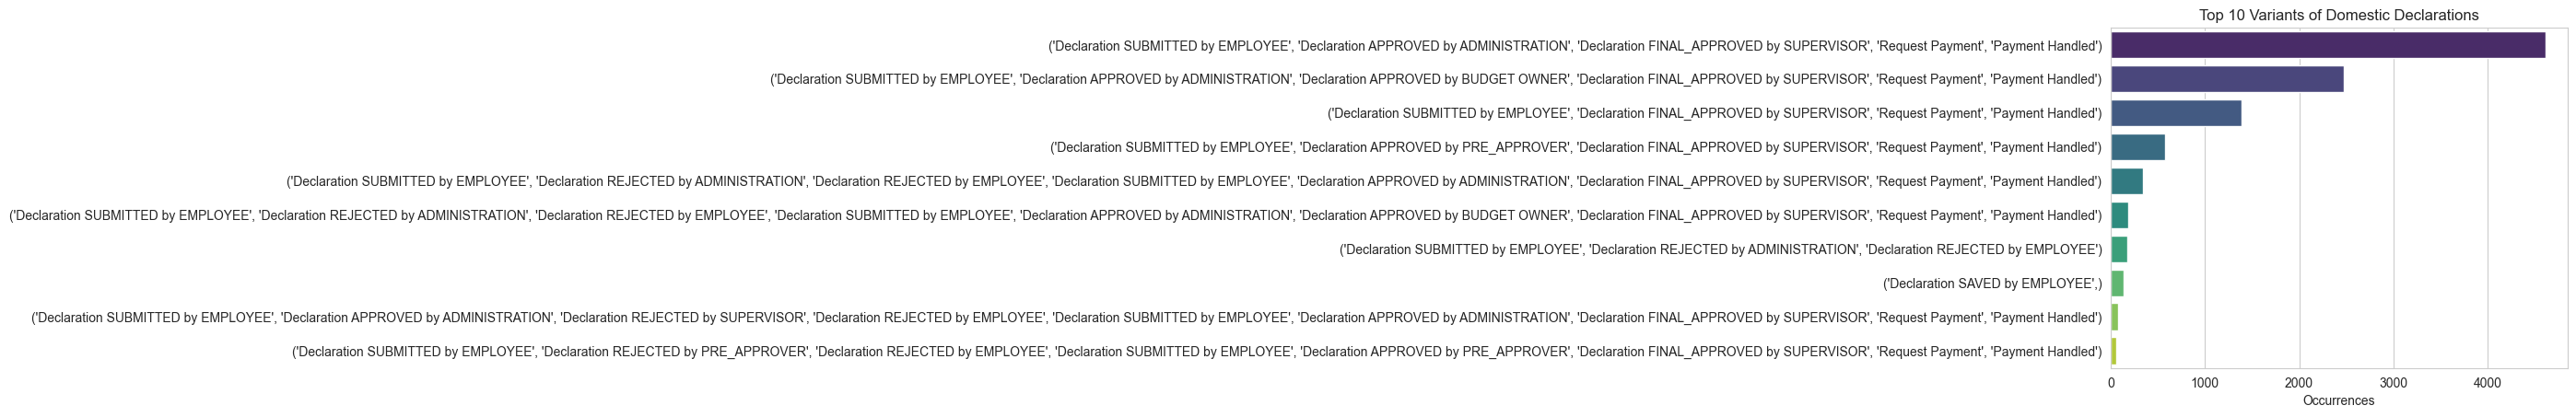

In [68]:
plot_top_n_variants(
    log_d, n_vars=10, 
    title='Top 10 Variants of Domestic Declarations'
)

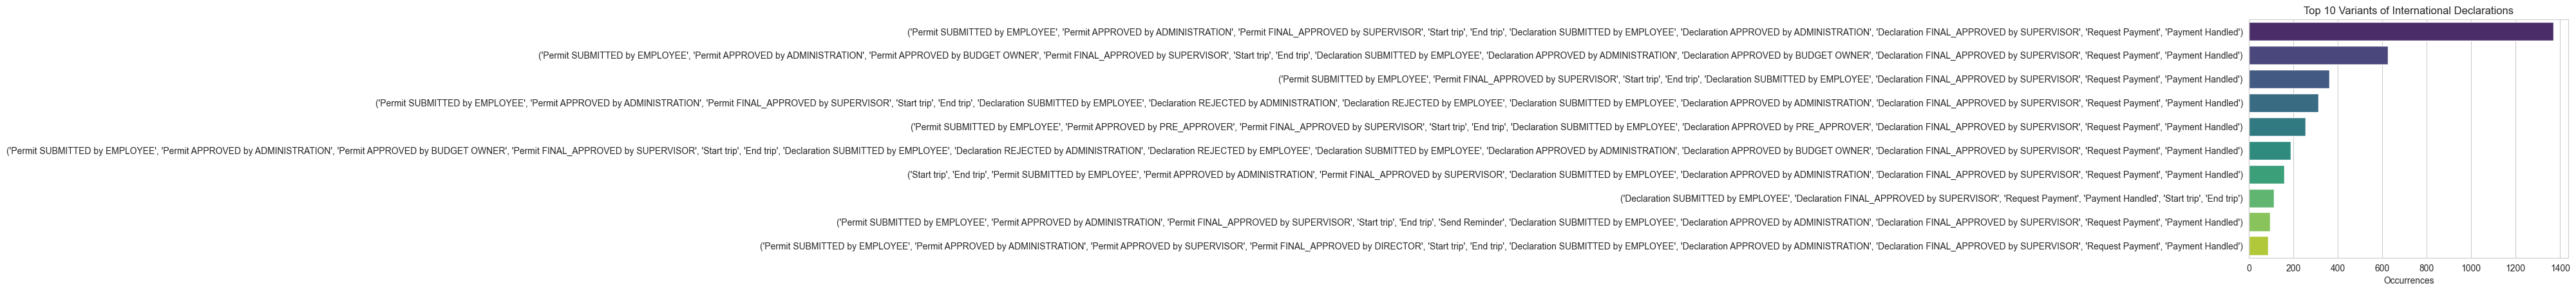

In [69]:
plot_top_n_variants(
    log_i, n_vars=10, 
    title='Top 10 Variants of International Declarations'
)

In [70]:
print(f'For domestic declarations: {count_cases_ratio(log_d, n_vars=10)}')
print(f'For international declarations: {count_cases_ratio(log_i, n_vars=10)}')

For domestic declarations: Top 10 variants account for 10,033 cases out of 10,500.
For international declarations: Top 10 variants account for 3,554 cases out of 6,449.


From the graphs above, we can observe that the international traces exhibit greater diversity compared to the domestic ones. 
This is primarily due to the combination of permit and declaration workflows within a single trace.

Interestingly, all the top seven variants of both international and domestic traces conclude with two system actions: "Request Payment" followed by "Payment Handled."

When examining the top six international traces, it becomes apparent that the initial part of each trace comprises actions related to the permit workflow, 
preceded by "Start trip" and "End trip" actions. Following this, the traces transition into actions associated with declarations.

## Petri Net

We will continue our process exploration by constructing a Petri Net for the international and domestic datasets.

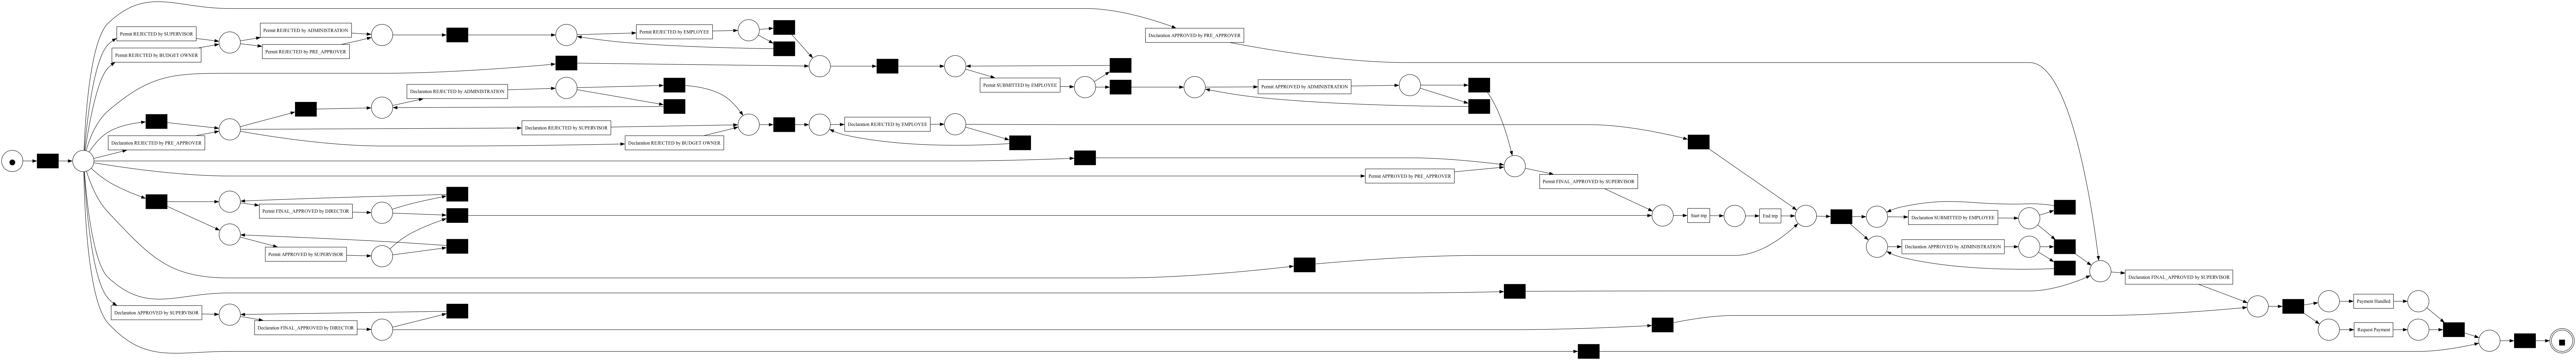

In [71]:
p_net_i, im_i, fm_i = pm4py.discover_petri_net_inductive(
    log=log_i,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(p_net_i, im_i, fm_i)

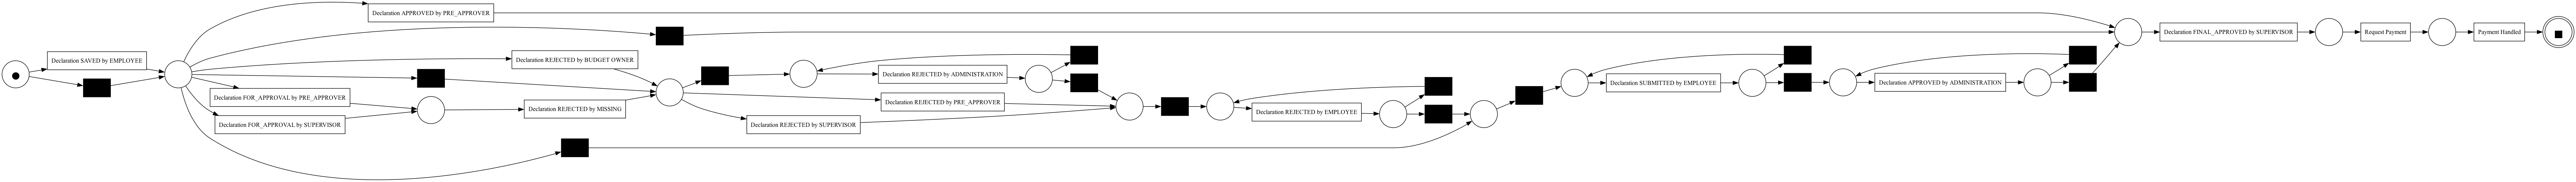

In [72]:
p_net_d, im_d, fm_d = pm4py.discover_petri_net_inductive(
    log=log_d,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(p_net_d, im_d, fm_d)

After constructing a Petri Net using the unfiltered datasets, we are faced with the question: 
would it be beneficial to filter out the most frequent process chains in order to create a more comprehensive process description?

Based on our previous analysis, it is evident that the international workflows demonstrate a clear distinction between permit and declaration flows. If this distinction holds true, 
combining the declaration process from the international dataset with the domestic dataset could prove advantageous. 
This would allow us to develop a more generalized process description that encompasses both international and domestic workflows.

Additionally, we can utilize insights from the exploratory data analysis conducted earlier to further refine our dataset, 
in particularly we will choose top 6 international variants and top 3 domestic variants.
This includes filtering out traces with "zero value amounts" as well as removing duplicated logs in the international dataset.

In [73]:
# get top most common variants, using charts above
top_6_variants_i = get_variants_df(log_i)[:6]['variant_trace'].tolist()
top_3_variants_d = get_variants_df(log_d)[:3]['variant_trace'].tolist()

# filter out traces with top 6 variants
log_i_filtered = log_i[~log_i['case:concept:name'].isin(top_6_variants_i)]
log_d_filtered = log_d[~log_d['case:concept:name'].isin(top_3_variants_d)]

# filter out international traces with duplicated logs
duplicated_traces_i = log_i[log_i.groupby('id')['case:concept:name'].transform('nunique').gt(1)]['case:concept:name'].unique()
log_i_filtered = log_i_filtered[~log_i_filtered['case:concept:name'].isin(duplicated_traces_i)]

# filter out traces with zero value amounts
zero_amount_traces_i = log_i_filtered[log_i_filtered['case:Amount'] == 0]['case:concept:name'].unique()
zero_amount_traces_d = log_d_filtered[log_d_filtered['case:Amount'] == 0]['case:concept:name'].unique()

log_i_filtered = log_i_filtered[~log_i_filtered['case:concept:name'].isin(zero_amount_traces_i)]
log_d_filtered = log_d_filtered[~log_d_filtered['case:concept:name'].isin(zero_amount_traces_d)]

In [74]:
# combine international and domestic datasets for declarations
log_i_filtered_declarations = log_i_filtered[log_i_filtered['concept:name'].str.contains('Declaration')]
log_d_filtered_declarations = log_d_filtered[log_d_filtered['concept:name'].str.contains('Declaration')]

log_declarations = pd.concat([log_i_filtered_declarations, log_d_filtered_declarations])
log_permissions = log_i_filtered[log_i_filtered['concept:name'].str.contains('Permit')]

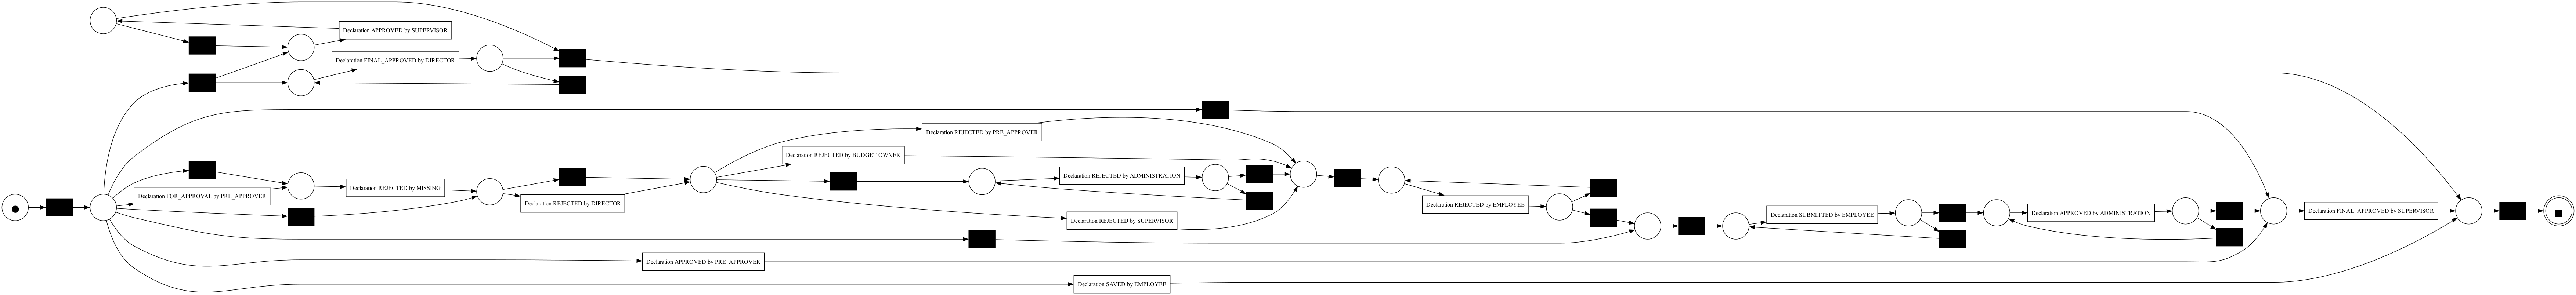

In [80]:
p_net_dec, im_dec, fm_dec = pm4py.discover_petri_net_inductive(
    log=log_declarations,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(p_net_dec, im_dec, fm_dec)

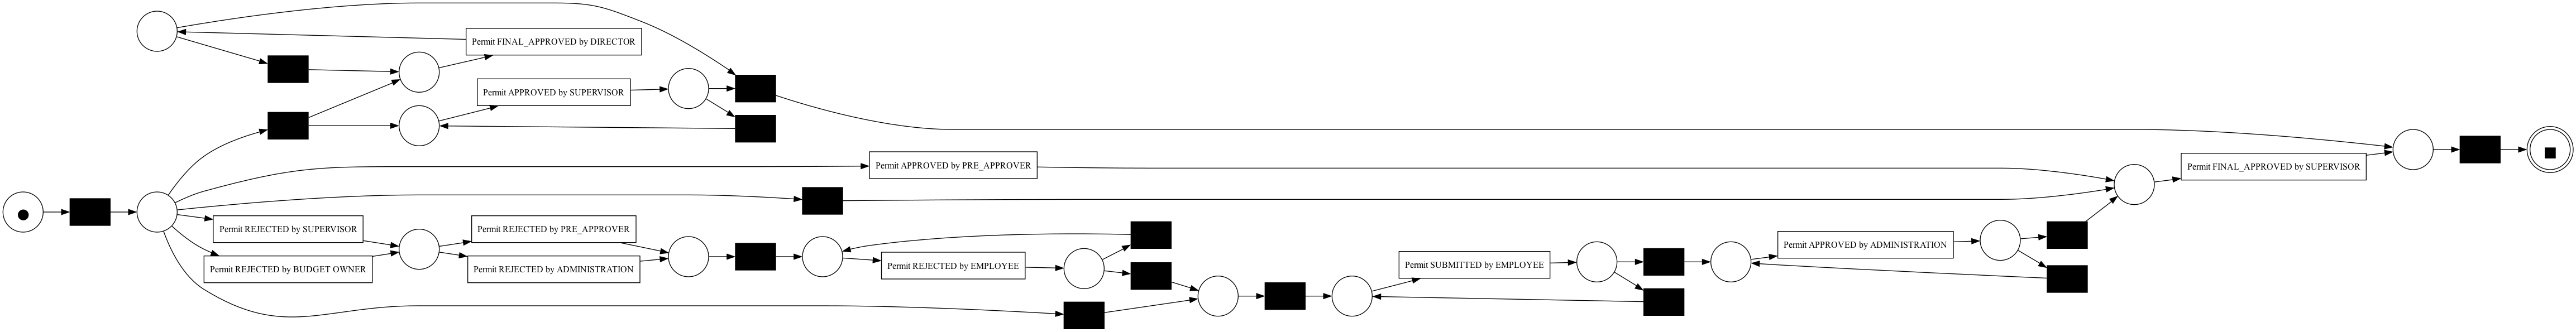

In [79]:
p_net_per, im_per, fm_per = pm4py.discover_petri_net_inductive(
    log=log_permissions,
    noise_threshold=.8,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:id'
)
pm4py.view_petri_net(p_net_per, im_per, fm_per)

Splitting the process into declarations and permissions allows us to clearly identify the workflows.

Workflows for permission and declarations follows similar patterns.
We can observe two branches: rejection and approval. 
If a submission is rejected, it leads to a new submission that can be approved by the ADMINISTRATION.

The approval branch is more straightforward. 
The permit must ultimately be approved either by the SUPERVISOR or by the DIRECTOR. 
However, in some cases, it may require pre-approval from other roles as well.